## How to Build a Recommendation Engine That Isn’t Movielens

Max Humber 

- [Twitter](https://twitter.com/maxhumber)
- [LinkedIn](https://www.linkedin.com/in/maxhumber/)
- [GitHub](https://github.com/maxhumber)

Abstract:

> Recommendation engines are pretty simple. Or at least, they are made to seem simple by an uncountable number of online tutorials. The only problem: **it’s hard to find a tutorial that doesn’t use** the ready-made and pre-baked **MovieLens** dataset. Fine. But, perhaps you’ve followed one of these tutorials and have struggled to imagine how to, or otherwise implement your own recommendation engine on your own data. In this workshop, I’ll show you how to use industry-leading open source tools to **build your own engine** and how to **structure your own data** so that it might be “recommendation-compatible”.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### MovieLens

![](images/movielens.png)

### Quickstart

```sh
pip install lightfm
```

In [2]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

data = fetch_movielens(min_rating=5.0)
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

precision_at_k(model, data['test'], k=5).mean()

0.05310436

In [3]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 19048 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 2153 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [4]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

### Data

![](images/halloween.png)

![](images/candy.jpg)

![](images/influenster.png)

This was working on 2019-10-19:

```python
import time
import json
import random
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from gazpacho import Soup
from tqdm import tqdm
import pandas as pd

options = Options()
options.headless = True
browser = Firefox(options=options)

def make_soup(url):
    browser.get(url)
    html = browser.page_source
    soup = Soup(html)
    return soup

def build_review_url(product, page):
    base = 'https://www.influenster.com'
    url = f'{base}/{product}?review_sort=most+recent&review_page={page}'
    return url

def parse_review(product, review):
    stars = int(review.find('div', {'class': 'avg-stars'}).attrs['data-stars'])
    user = review.find('div', {'class': 'content-item-author-info'}).find('a').attrs['href'][1:]
    return {'product': product, 'user': user, 'stars': stars}

def scrape_product_page(product, page):
    url = build_review_url(product, page)
    soup = make_soup(url)
    page_reviews = soup.find('div', {'class': 'content-item review-item'})
    return [parse_review(product, r) for r in page_reviews]

def scrape_product(product):
    url = build_review_url(product, 1)
    soup = make_soup(url)
    pages = int(
        soup.find('div', {'class': 'product-highlights-results'})
        .text
        .replace(',', '')
        .split(' ')[0]
    ) // 10 + 1
    pages = min(pages, 100)
    pages = list(range(1, pages+1))
    random.shuffle(pages)
    reviews = []
    for page in pages:
        print(f'scraping page: {page}')
        page_reviews = scrape_product_page(product, page)
        reviews.extend(page_reviews)
        time.sleep(random.randint(1, 10) / 10)
    return reviews

def scrape_index(category='sweets-candy-gum'):
    product_index = []
    for page in tqdm(range(1, 10+1)):
        url = f'https://www.influenster.com/reviews/{category}?page={page}'
        soup = make_soup(url)
        products = soup.find('a', {'class': 'category-product'}, strict=True)
        products = [p.attrs['href'] for p in products]
        candy.extend(products)
        time.sleep(random.randint(1, 10) / 10)
    return product_index

if __name__ == '__main__':

    product_index = scrape_index(category='sweets-candy-gum')

    product_reviews = []
    for product in tqdm(product_index):
        print(f'scraping: {product}')
        try:
            reviews = scrape_product(product)
            product_reviews.extend(reviews)
        except:
            pass
        time.sleep(random.randint(1, 10) / 10)

    df = pd.DataFrame(product_reviews)
    df.to_csv('data/candy.csv', index=False)
```

![](images/cat_and_mouse.jpg)

### Scrape 

![](images/influenster_index.png)

[Source](https://www.influenster.com/reviews/sweets-candy-gum)

In [5]:
with open('influenster/index.html', 'r') as f:
    html = f.read()

![](images/gazpacho.png)

```
pip install gazpacho
```

In [6]:
from gazpacho import Soup

In [7]:
soup = Soup(html)

In [8]:
products = soup.find('a', {'class': 'category-product'})

In [9]:
products[0]

<a class="category-product" href="https://www.influenster.com/reviews/reeses-peanut-butter-cups-miniatures-76"><div class="category-product-image-container"><div class="category-product-image" style="background-image: url("index_files/51107862.jpg");"><img itemprop="image" data-img="div" src="index_files/51107862.jpg" alt="Reese's Peanut Butter Cups Miniatures" width="0" height="0"></div></div><div class="category-product-detail"><div class="category-product-title" data-truncate-lines="3" style="overflow-wrap: break-word;">Reese's Peanut Butter Cups Miniatures</div><div class="category-product-brand">
By Reese's
</div><div class="category-product-stars"><div class="avg-stars small " data-stars="4.82880054868237"><div class="star"><i class="star-icon"></i><div class="progress" data-star="1" data-progress="100"></div></div><div class="star"><i class="star-icon"></i><div class="progress" data-star="2" data-progress="100"></div></div><div class="star"><i class="star-icon"></i><div class="p

In [10]:
products = [p.attrs['href'] for p in products]

In [11]:
products[:5]

['https://www.influenster.com/reviews/reeses-peanut-butter-cups-miniatures-76',
 'https://www.influenster.com/reviews/ferrero-rocher-chocolate',
 'https://www.influenster.com/reviews/kit-kat-crisp-wafers-in-milk-chocolate',
 'https://www.influenster.com/reviews/lindt-lindor-milk-chocolate-truffles',
 'https://www.influenster.com/reviews/hersheys-cookies-n-creme-candy-bar']

![](images/influenster_skittles.png)

In [12]:
with open('influenster/skittles.html', 'r') as f:
    html = f.read()

In [13]:
soup = Soup(html)

In [14]:
reviews = (soup
    .find('div', {'class': 'layoutComponents__Block-l2otzz-0 efHRYv'}, strict=True)
    .find('div', {'class': 'item wrappers__Wrapper-sc-1mex847-0 jEYnle'})
)

In [15]:
str(reviews[0])[:500]

'<div class="item wrappers__Wrapper-sc-1mex847-0 jEYnle">\n                                            <div class="author-card authorCard__AuthorCardWrapperDesktop-sc-26la3e-1 hAEwt"><a aria-label="anahce0f" href="/anahce0f">\n                                                    <div class="mediaComponents__ImageContainer-sc-1gsoaz-0 bEUCqQ" style="border-radius:50%" size="70"></div>\n                                                </a>\n                                                <div>\n          '

In [16]:
# activity > parse review 5 minutes

In [17]:
def parse_review(review):
    stars = len(review.find('div', {'class': 'productComponents__SingleStar-sc-1ffpes9-3 kzXpnS'}))
    user = (review.find('div',
        {'class': 'layoutComponents__Row-l2otzz-2 MSbai layoutComponents__Block-l2otzz-0 ixyxcj'}
        ).find('a').attrs['href'])[1:]
    return {'user': user, 'stars': stars}

In [18]:
review = reviews[0]
parse_review(review)

{'user': 'anahce0f', 'stars': 5}

In [19]:
candy = [parse_review(r) for r in reviews]
candy

[{'user': 'anahce0f', 'stars': 5},
 {'user': 'rileyc2ef0', 'stars': 5},
 {'user': 'danielledowsett', 'stars': 5},
 {'user': 'candygirl7585', 'stars': 5},
 {'user': 'marnishaw', 'stars': 5},
 {'user': 'megfields', 'stars': 4},
 {'user': 'member-a58a7cd88', 'stars': 4},
 {'user': 'darcywood', 'stars': 5},
 {'user': 'amandaj64', 'stars': 5},
 {'user': 'member-930e4ca64', 'stars': 4}]

In [20]:
import pandas as pd

df = pd.DataFrame(candy)
df['item'] = 'skittles'
df

,stars,user,item
0,5,anahce0f,skittles
1,5,rileyc2ef0,skittles
2,5,danielledowsett,skittles
3,5,candygirl7585,skittles
4,5,marnishaw,skittles
5,4,megfields,skittles
6,4,member-a58a7cd88,skittles
7,5,darcywood,skittles
8,5,amandaj64,skittles
9,4,member-930e4ca64,skittles


### EDA

In [21]:
import pandas as pd

df = pd.read_csv('data/candy.csv')

df.sample(5)

,item,user,review
13140,Reese's Pieces Peanut Butter Candy,zjones,5
1036,Jolly Rancher Sugar Free Hard Candy,brittanyrichard,5
3432,5 Gum,smithjenny,3
6970,Reese's Peanut Butter Cups Miniatures,rojasjoseph,5
7700,Snickers Chocolate Bar,douglasalvarez,5


In [22]:
df['item'].value_counts()[:5]

Twix                                       340
Snickers Chocolate Bar                     330
Werther's Original Caramel Hard Candies    322
M&Ms Peanut Chocolate Candy                310
M&Ms Milk Chocolate Candy                  273
Name: item, dtype: int64

In [23]:
df['item'].unique().shape

(142,)

In [24]:
df['user'].unique().shape

(2531,)

In [25]:
import chart # pip install chart

chart.histogram(df['review'], bins=5, height=20, mark='x')

        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
        x
      x x
      x x
      x x
x x x x x



In [26]:
df['review'].value_counts()

5    12977
4     2554
3      967
2      372
1      364
Name: review, dtype: int64

In [27]:
df.groupby('user')['item'].count().mean()

6.809166337416041

### Sparsity

In [28]:
ex = pd.DataFrame([
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 1]], 
    columns=['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6'])

ex

,item_1,item_2,item_3,item_4,item_5,item_6
0,0,1,1,0,0,0
1,0,1,1,1,0,0
2,1,0,0,1,0,0
3,0,1,1,0,0,1
4,0,0,0,1,1,1


In [29]:
r, c = ex.shape
ex.sum().sum() / (r * c)

0.43333333333333335

In [30]:
import sys

sys.getsizeof(ex)

344

In [31]:
ex.values

array([[0, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1]])

In [32]:
from scipy.sparse import csc_matrix

sx = csc_matrix(ex.values)

In [33]:
sys.getsizeof(sx)

56

### Sparse Candy

In [34]:
df.sample(5)

,item,user,review
2167,Skittles Sour Candy,berrybrian,4
14521,Hershey's Nuggets Milk Chocolate with Almonds,xschwartz,5
239,Twix,qlambert,4
4668,Pez Candy,qmedina,5
15220,Trident Gum,perezolivia,3


In [35]:
import numpy as np

In [36]:
ratings='review'
users='user'
items='item'

ratings = np.array(df[ratings])
users = np.array(df[users])
items = np.array(df[items])

In [37]:
from scipy.sparse import csr_matrix

help(csr_matrix)

Help on class csr_matrix in module scipy.sparse.csr:

class csr_matrix(scipy.sparse.compressed._cs_matrix, scipy.sparse.sputils.IndexMixin)
 |  csr_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indpt

In [38]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])

csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]], dtype=int64)

In [39]:
from sklearn.preprocessing import LabelEncoder

# heavy lifting encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# preparation for the csr matrix
u = user_encoder.fit_transform(users)
i = item_encoder.fit_transform(items)
lu = len(np.unique(u))
li = len(np.unique(i))

In [40]:
interactions = csr_matrix((ratings, (u, i)), shape=(lu, li))

### Interaction Machine

In [41]:
class InteractionMachine:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()

    def __repr__(self):
        return 'InteractionMachine()'

    def build(self, users, items, ratings):
        u = self.user_encoder.fit_transform(users)
        i = self.item_encoder.fit_transform(items)
        self.n_users = len(np.unique(u))
        self.n_items = len(np.unique(i))
        self.interactions = csr_matrix((ratings, (u, i)), shape=(self.n_users, self.n_items))
        return self

In [42]:
im = InteractionMachine()
im.build(df['user'], df['item'], df['review'])
interactions = im.interactions

### Basic LightFM 

In [43]:
model = LightFM()

In [44]:
model.fit(interactions)

In [45]:
model.predict(0, [1, 2, 3])

array([0.56409514, 0.97231287, 0.67681968])

### Evaluation

In [46]:
from lightfm.evaluation import auc_score, precision_at_k

> AUC measures the quality of the overall ranking. In the binary case, it can be interpreted as the probability that a randomly chosen positive item is ranked higher than a randomly chosen negative item. Consequently, an AUC close to 1.0 will suggest that, by and large, your ordering is correct: and this can be true even if none of the first K items are positives. This metric may be more appropriate if you do not exert full control on which results will be presented to the user; it may be that the first K recommended items are not available any more (say, they are out of stock), and you need to move further down the ranking. A high AUC score will then give you confidence that your ranking is of high quality throughout.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

> Precision@K measures the proportion of positive items among the K highest-ranked items. As such, it's very focused on the ranking quality at the top of the list: it doesn't matter how good or bad the rest of your ranking is as long as the first K items are mostly positive. This would be an appropriate metric if you are only ever going to be showing your users the very top of the list.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

In [47]:
auc_score(model, interactions).mean()

0.65184253

In [48]:
precision_at_k(model, interactions, k=10).mean()

0.110944286

### train-test-split

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
train_test_split(interactions)

[<1898x142 sparse matrix of type '<class 'numpy.int64'>'
 	with 12867 stored elements in Compressed Sparse Row format>,
 <633x142 sparse matrix of type '<class 'numpy.int64'>'
 	with 4332 stored elements in Compressed Sparse Row format>]

### Traditional 

![](images/tts_traditional.png)

### Recommendation

![](images/tts_reco.png)

In [51]:
from lightfm.cross_validation import random_train_test_split

In [52]:
train, test = random_train_test_split(interactions, test_percentage=0.2)

### Training Cycle

In [53]:
model = LightFM()
model.fit(train, epochs=500)

In [54]:
auc_score(model, test).mean()

0.67178357

In [55]:
model = LightFM()

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

In [56]:
from matplotlib import pyplot as plt

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Loss

> WARP: Weighted Approximate-Rank Pairwise loss. Maximises
  the rank of positive examples by repeatedly sampling negative
  examples until rank violating one is found. Useful when only
  positive interactions are present and optimising the top of
  the recommendation list (precision@k) is desired.

In [57]:
# exercise > try a couple of epoch and loss combinations

In [58]:
model = LightFM(loss='warp')

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

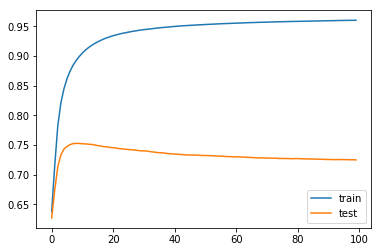

In [59]:
from matplotlib import pyplot as plt

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Early Stopping

In [60]:
from copy import deepcopy

model = LightFM(loss='warp')

count = 0
best = 0
scores = []
for e in range(100):
    if count > 5: # patience
        break
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    print(f'Epoch: {e}, Train AUC={auc_train:.3f}, Test AUC={auc_test:.3f}')
    scores.append((auc_train, auc_test))
    if auc_test > best:
        best_model = deepcopy(model)
        best = auc_test
    else:
        count += 1

model = deepcopy(best_model)

Epoch: 0, Train AUC=0.645, Test AUC=0.631
Epoch: 1, Train AUC=0.717, Test AUC=0.677
Epoch: 2, Train AUC=0.776, Test AUC=0.713
Epoch: 3, Train AUC=0.811, Test AUC=0.732
Epoch: 4, Train AUC=0.835, Test AUC=0.742
Epoch: 5, Train AUC=0.853, Test AUC=0.747
Epoch: 6, Train AUC=0.866, Test AUC=0.751
Epoch: 7, Train AUC=0.877, Test AUC=0.754
Epoch: 8, Train AUC=0.887, Test AUC=0.756
Epoch: 9, Train AUC=0.894, Test AUC=0.757
Epoch: 10, Train AUC=0.901, Test AUC=0.756
Epoch: 11, Train AUC=0.906, Test AUC=0.756
Epoch: 12, Train AUC=0.911, Test AUC=0.756
Epoch: 13, Train AUC=0.915, Test AUC=0.755
Epoch: 14, Train AUC=0.918, Test AUC=0.755
Epoch: 15, Train AUC=0.921, Test AUC=0.753


### New Predictions

In [61]:
user = 'aaron67'
df[df['user'] == user]

,item,user,review
13806,Mike and Ike Sour Licious Zours,aaron67,4
14073,Kit Kat Minis Crisp Wafers in Milk Chocolate,aaron67,5
14396,Reese's Peanut Butter Cup Pumpkins Milk Chocolate,aaron67,5
15153,Snickers Crisper Chocolate Bar,aaron67,1
15296,Snickers Peanut Butter Squared Bars,aaron67,5
16867,Reese's Peanut Butter Heart,aaron67,5


In [62]:
user_id = user_encoder.transform([user])[0]

In [63]:
preds = model.predict(user_id, list(range(li)))
preds = pd.DataFrame(zip(preds, item_encoder.classes_), columns=['pred', 'item'])
preds = preds.sort_values('pred', ascending=False)
preds.head()

,pred,item
92,1.344560,Reese's Peanut Butter Cup Pumpkins Milk Chocolate
81,0.815100,Nestle Baby Ruth Bar
45,0.594204,Hershey's Nuggets Milk Chocolate with Almonds
40,0.558297,Hershey's Kisses Milk Chocolates with Almonds
43,0.520468,Hershey's Natural Unsweetened Cocoa


In [64]:
tried = df[df['user'] == user]['item'].values
list(preds[~preds['item'].isin(tried)]['item'].values[:5])

['Nestle Baby Ruth Bar',
 "Hershey's Nuggets Milk Chocolate with Almonds",
 "Hershey's Kisses Milk Chocolates with Almonds",
 "Hershey's Natural Unsweetened Cocoa",
 'Lindt Lindor Stracciatella Chocolate']

### New Users

![](images/sol.png)

### Unless...

In [65]:
ex = pd.DataFrame([
    [0, 1, 1, 0, 0, 0], 
    [0, 1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 1]
])

In [66]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(ex)

array([[0.        , 1.        , 2.        , 1.        , 2.23606798],
       [1.        , 0.        , 1.73205081, 1.41421356, 2.        ],
       [2.        , 1.73205081, 0.        , 2.23606798, 1.73205081],
       [1.        , 1.41421356, 2.23606798, 0.        , 2.        ],
       [2.23606798, 2.        , 1.73205081, 2.        , 0.        ]])

In [67]:
df = pd.read_csv("data/candy.csv")
df = df[df['review'] >= 4]

In [68]:
df.sample(5)

,item,user,review
2860,Reese's Peanut Butter Cup Pumpkins Milk Chocolate,charles70,5
11171,Butterfinger Peanut Butter Cups Minis,jonesalyssa,5
8955,Hershey's Nuggets Milk Chocolate with Almonds,lindsaylewis,5
9550,Life Savers Five Flavor Gummies,brandonwhite,5
14298,Reese's Reeses Peanut Butter Trees,robertwhitney,5


In [69]:
df = df.groupby(["user"])["item"].apply(lambda x: ",".join(x))
df = pd.DataFrame(df)
df.head()

,item
user,
aaron67,"Mike and Ike Sour Licious Zours,Kit Kat Minis ..."
aaron68,"Hubba Bubba Bubbletape Awesome Original,Brooks..."
aaron73,Dove Chocolate Promises Silky Smooth Sea Salt ...
abarker,"Reese's Peanut Butter Bunny,Ghirardelli Gourme..."
abigail04,"Kit Kat Minis Crisp Wafers in Milk Chocolate,P..."


In [70]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=lambda x: x.split(","), max_features=250)
X = cv.fit_transform(df['item'])

In [71]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [72]:
neighbors = nn.kneighbors(X, return_distance=False)
neighbors

array([[   0, 2042,  920,  186, 1625],
       [   1,  404, 2424, 1110, 2370],
       [   2, 2221,  677, 1386,  739],
       ...,
       [2525,  620,  782,  661, 1546],
       [2526,  308, 2236,  177,  801],
       [2527, 1252, 1350, 2111, 2346]])

In [73]:
neighbors[0]

array([   0, 2042,  920,  186, 1625])

In [74]:
candy = []
for n in neighbors[0]:
    c = df.iloc[int(n)].values[0].split(",")
    candy.extend(c)
    
list(set(candy))

["Hershey's Natural Unsweetened Cocoa",
 'Jet Puffed Stackermallows Marshmallows',
 'Kit Kat Minis Crisp Wafers in Milk Chocolate',
 'Mike and Ike Sour Licious Zours',
 'Snickers Peanut Butter Squared Bars',
 'Sour Punch Real Rainbow Straws',
 'Nestle Butterfinger Bites',
 'Kraft Vanilla Caramels Snack Bags',
 'Kirkland Milk Chocolate Almonds',
 "Reese's Peanut Butter Cup Pumpkins Milk Chocolate",
 "Reese's Peanut Butter Heart",
 'Mounds Candy Bar',
 'Airheads Bites Fruit']

### Putting a bow on it

In [75]:
df = pd.read_csv("data/candy.csv")
df = df[df['review'] >= 4]
df = df.groupby(["user"])["item"].apply(lambda x: ",".join(x))
df = pd.DataFrame(df)
df.head()

,item
user,
aaron67,"Mike and Ike Sour Licious Zours,Kit Kat Minis ..."
aaron68,"Hubba Bubba Bubbletape Awesome Original,Brooks..."
aaron73,Dove Chocolate Promises Silky Smooth Sea Salt ...
abarker,"Reese's Peanut Butter Bunny,Ghirardelli Gourme..."
abigail04,"Kit Kat Minis Crisp Wafers in Milk Chocolate,P..."


In [76]:
class NNRecommender:
    def __init__(
        self, n_neighbors=5, max_features=250, tokenizer=lambda x: x.split(",")):
        self.cv = CountVectorizer(tokenizer=tokenizer, max_features=max_features)
        self.nn = NearestNeighbors(n_neighbors=n_neighbors)

    def fit(self, X):
        self.X = X
        X = self.cv.fit_transform(X)
        self.nn.fit(X)
        return self

    def predict(self, X):
        Xp = []
        for Xi in X:
            Xt = self.cv.transform([Xi])
            _, neighbors = self.nn.kneighbors(Xt)
            repos = []
            for n in neighbors[0]:
                r = self.X.iloc[int(n)].split(",")
                repos.extend(r)
            repos = list(set(repos))
            repos = [r for r in repos if r not in Xi.split(",")]
            Xp.append(repos)
        return Xp

In [77]:
n_neighbors = 5
max_features = 250
model = NNRecommender(n_neighbors, max_features)
model.fit(df["item"])

In [78]:
df.sample(1)['item'].values

array(["Hershey's Kisses Milk Chocolate,Demets Turtles Original,Dove Chocolate Silky Smooth Dark Chocolate Large Bar,Nestle Baby Ruth Bar,Milky Way Simply Caramel Bar"],
      dtype=object)

In [79]:
sweet = ["Airheads Xtremes Sweetly Sour Candy Rainbow Berry,Life Savers Five Flavor Gummies,Twizzlers Pull-N-Peel Candy Cherry"]

In [80]:
peanut = ["Reese's Peanut Butter Cups Miniatures,M&Ms Peanut Chocolate Candy,Reese's Peanut Butter Big Cup"]

In [81]:
model.predict(sweet)

[['Warheads Extreme Sour Hard Candy',
  'Brookside Dark Chocolate Pomegranate Flavor',
  'Mars Candy Fun Size Mix Peanut And Peanut Butter Lovers',
  'Starburst Original',
  'Demets Turtles Original',
  'Starburst Original Jelly Beans',
  'Trolli Sour Brite Eggs Candy']]

In [82]:
model.predict(peanut)

[["Reese's Peanut Butter Egg",
  "Reese's Outrageous King Size Bar",
  'Ferrero Rocher Chocolate',
  'Twix',
  "Hershey's Cookies 'n' Creme Candy Bar",
  'Snickers Chocolate Bar',
  '3 Musketeers Candy Bar']]